In [17]:
import os
import csv
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter 

In [ ]:
BASE_URL = "https://api.covidtracking.com/v1"

# Define all endpoints
endpoints = {
    "us_daily": "/us/daily.json",
    "states_daily": "/states/daily.json",
}

# Fetch and save data for each endpoint
for name, endpoint in endpoints.items():
    url = BASE_URL + endpoint

    response = requests.get(url)
    response.raise_for_status()  # Raises an HTTPError for bad responses
    
    data = response.json()
    
    # Handle case where data might be a list of dictionaries or a single dictionary
    if isinstance(data, list):
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame([data])  # Wrap single dict in a list
        
    df.to_csv(f"{name}.csv", index=False)
    print(f"✅ Successfully saved {name}.csv")

In [ ]:
# Load datasets
us_current = pd.read_csv("us_current.csv")
states_daily = pd.read_csv("states_daily.csv")
states_current = pd.read_csv("states_current.csv")
states_info = pd.read_csv("states_info.csv")

## US Daily

### Description

1. Let's investigate what kind of data we have in us_daily.csv
2. Let's detect outlier data
3. Analyze missing values
4. Prepare the ETL
5. Choose variables, how can I relate them with other variables to analyze?

In [ ]:
# Load dataset
us_daily = pd.read_csv("us_daily.csv")

In [53]:
# Let's check the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(us_daily.tail())

       date  states    positive    negative  pending  hospitalizedCurrently  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  onVentilatorCurrently  onVentilatorCumulative           dateChecked     death  hospitalized  totalTestResults lastModified  recovered  total  posNeg  deathIncrease  hospitalizedIncrease  negativeIncrease  positiveIncrease  totalTestResultsIncrease                                      hash
4  20210303      56  28520365.0  73857281.0  11778.0                45462.0                770821.0          9359.0          45214.0                 3094.0                  4260.0  2021-03-03T24:00:00Z  508665.0      770821.0         357888671   2021-03-03        NaN      0       0           2449                  2172            267001             66836                   1406795  fef6c425d2b773a9221fe353f13852f3e4a4bfb0
3  20210304      56  28585852.0  74035238.0  12405.0                44172.0                772351.0          8970.0          45293.0                 297

In [9]:
# Clean dataset
us_daily['clean_date'] = pd.to_datetime(us_daily['lastModified'].str.extract(r'(.*?)T')[0])


=== POSITIVEINCREASE === (IQR Method)
Total days: 420
Outlier days: 40 (9.5%)
Outlier details:
clean_date  positiveIncrease
2020-11-20            197164
2020-11-27            198874
2020-12-02            203429
2020-12-03            216271
2020-12-04            230313
2020-12-05            219070
2020-12-08            217844
2020-12-09            216728
2020-12-10            220846
2020-12-11            236933
2020-12-12            226904
2020-12-14            193286
2020-12-15            193218
2020-12-16            234288
2020-12-17            242970
2020-12-18            241786
2020-12-19            204873
2020-12-20            197494
2020-12-22            193008
2020-12-23            224526
2020-12-24            206684
2020-12-26            190594
2020-12-29            199679
2020-12-30            229496
2020-12-31            226246
2021-01-02            280318
2021-01-03            208457
2021-01-05            219075
2021-01-06            250184
2021-01-07            272043
2021-

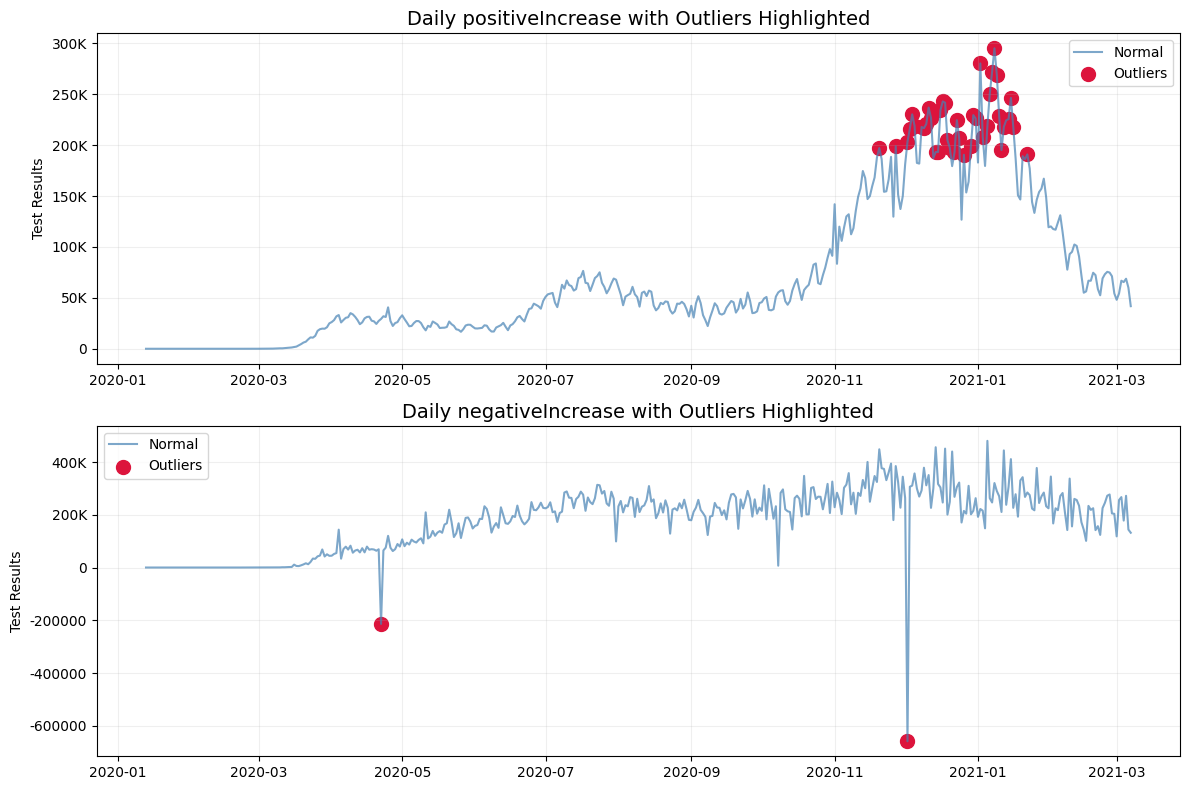


Days with BOTH positive and negative test outliers:
clean_date  positiveIncrease  negativeIncrease
2020-12-02            203429           -658774


In [21]:
cols = ['positiveIncrease', 'negativeIncrease']  # Changed from 'positive'

def human_format(num):
    if num >= 1e6:
        return f'{num/1e6:.1f}M'
    return f'{num/1e3:.0f}K' if num >= 1000 else f'{num:.0f}'

def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return (data < lower) | (data > upper)

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols, 1):
    outliers = detect_outliers_iqr(us_daily[col])
    
    print(f"\n=== {col.upper()} === (IQR Method)")
    print(f"Total days: {len(us_daily)}")
    print(f"Outlier days: {outliers.sum()} ({outliers.mean()*100:.1f}%)")
    print("Outlier details:")
    print(us_daily.loc[outliers, ['clean_date', col]].sort_values('clean_date').to_string(index=False))
    
    ax = plt.subplot(2, 1, i)
    
    plt.plot(us_daily['clean_date'], us_daily[col], 'steelblue', alpha=0.7, label='Normal')
    plt.scatter(us_daily.loc[outliers, 'clean_date'], us_daily.loc[outliers, col], c='crimson', s=100, label='Outliers')
    
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: human_format(x)))
    plt.title(f'Daily {col} with Outliers Highlighted', fontsize=14)
    plt.ylabel('Test Results', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.legend()

plt.tight_layout()
plt.show()

combined_outliers = us_daily[
    detect_outliers_iqr(us_daily['positiveIncrease']) & 
    detect_outliers_iqr(us_daily['negativeIncrease'])
]

print("\nDays with BOTH positive and negative test outliers:")
print(combined_outliers[['clean_date', 'positiveIncrease', 'negativeIncrease']].to_string(index=False))

In [29]:
# Fix lasModified
us_daily['lastModified'] = us_daily['lastModified'].str.replace('T24:00:00Z', 'T00:00:00Z')
us_daily['lastModified'] = pd.to_datetime(us_daily['lastModified'], format='%Y-%m-%dT%H:%M:%SZ')

us_daily = us_daily.sort_values('lastModified')

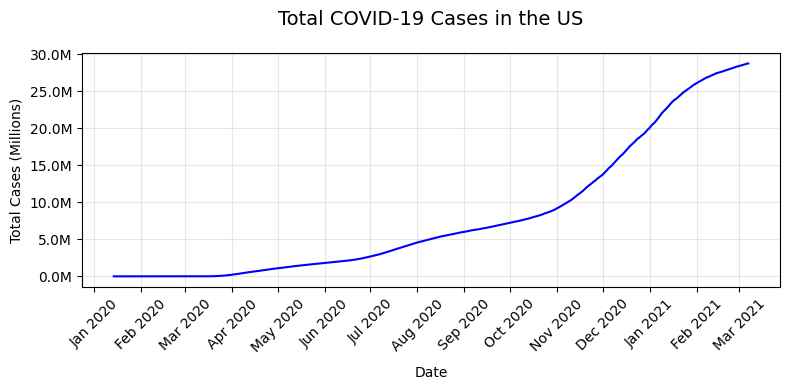

In [54]:
# Total positive cases in the US
plt.figure(figsize=(8, 4))

plt.plot(us_daily['lastModified'], us_daily['positive']/1e6, color='blue', linewidth=1.5)

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}M')) 


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Add labels
plt.title("Total COVID-19 Cases in the US", fontsize=14, pad=20)
plt.xlabel("Date", fontsize=10, labelpad=8)
plt.ylabel("Total Cases (Millions)", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

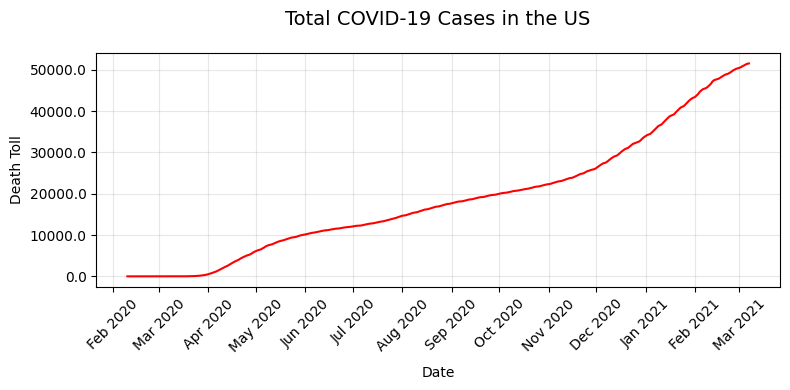

In [ ]:
# Total deaths in the US
plt.figure(figsize=(8, 4))

plt.plot(us_daily['lastModified'], us_daily['death'], color='red', linewidth=1.5)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10:.1f}'))


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Add labels
plt.title("Total COVID-19 Cases in the US", fontsize=14, pad=20)
plt.xlabel("Date", fontsize=10, labelpad=8)
plt.ylabel("Death Toll", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

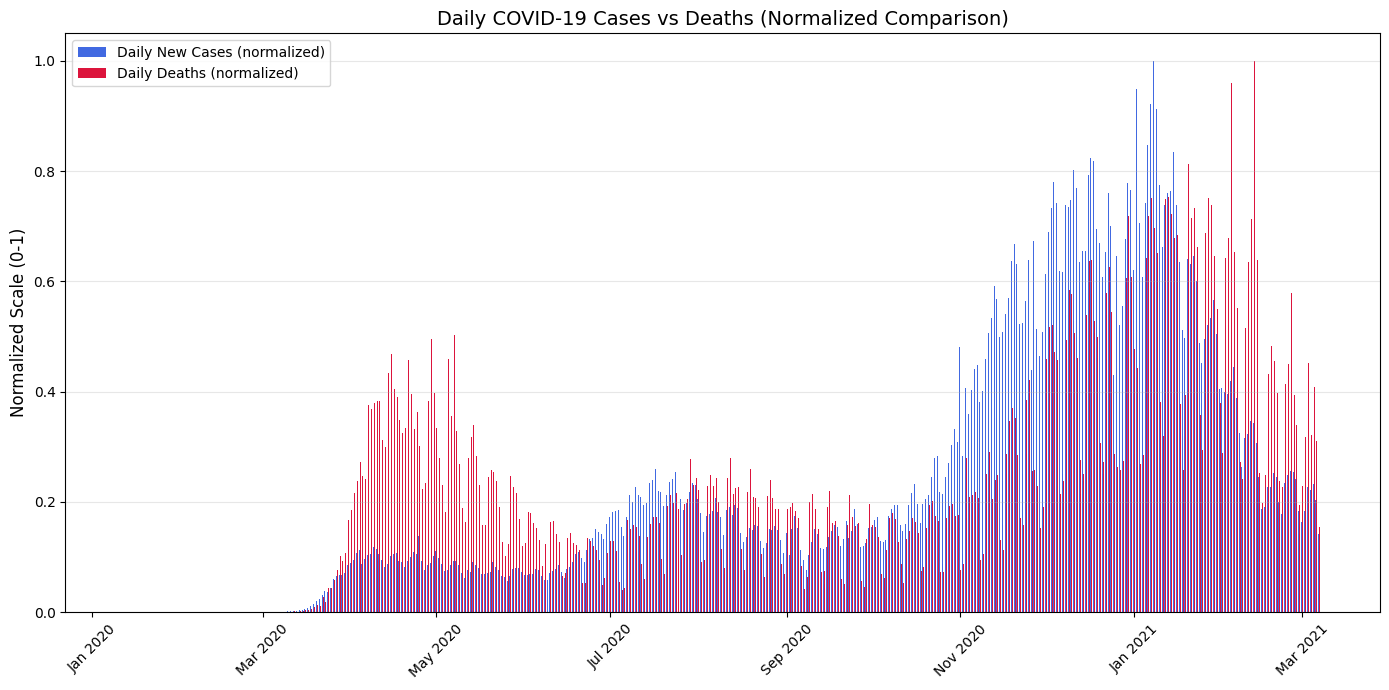

In [30]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate normalized values (0-1 scale)
cases_norm = us_daily['positiveIncrease'] / us_daily['positiveIncrease'].max()
deaths_norm = us_daily['deathIncrease'] / us_daily['deathIncrease'].max()

# Plot both as bars with different colors
width = 0.35  # Bar width
dates = mdates.date2num(us_daily['lastModified'])

ax.bar(dates - width/2, cases_norm, width, color='royalblue', label='Daily New Cases (normalized)')
ax.bar(dates + width/2, deaths_norm, width, color='crimson', label='Daily Deaths (normalized)')

# Formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

ax.set_ylabel('Normalized Scale (0-1)', fontsize=12)
plt.title('Daily COVID-19 Cases vs Deaths (Normalized Comparison)', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Load datasets
us_current = pd.read_csv("us_current.csv")
states_daily = pd.read_csv("states_daily.csv")
states_current = pd.read_csv("states_current.csv")
states_info = pd.read_csv("states_info.csv")